Прогнозирование уровня диммирования уличного освещения

Модель на основе Gradient Boosting для предсказания оптимального уровня освещения

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib
import warnings

warnings.filterwarnings('ignore')

In [50]:
df = pd.read_csv('device_data.csv')
print(f"Загружено {len(df)} записей")
df.head()

Загружено 400 записей


,id,timestamp,serial_number,latitude,longitude,car_count,traffic_speed,traffic_density,pedestrian_count,pedestrian_density,ambient_light,lighting_class,lamp_power,weather,dimming_level
0,1,2025-03-02T00:00:00,1,47.22486,39.702285,9,24.38,0.11,0,0.00,151.0,B1,75.0,rain,75.0
1,2,2025-03-02T01:00:00,1,47.22486,39.702285,7,30.23,0.09,2,0.05,98.0,B1,52.5,rain,80.0
2,3,2025-03-02T02:00:00,1,47.22486,39.702285,5,21.39,0.06,0,0.00,79.0,B1,52.5,rain,75.0
3,4,2025-03-02T03:00:00,1,47.22486,39.702285,4,23.99,0.05,0,0.00,20.0,B1,52.5,rain,75.0
4,5,2025-03-02T04:00:00,1,47.22486,39.702285,1,11.50,0.01,2,0.05,7.0,B1,52.5,rain,70.0


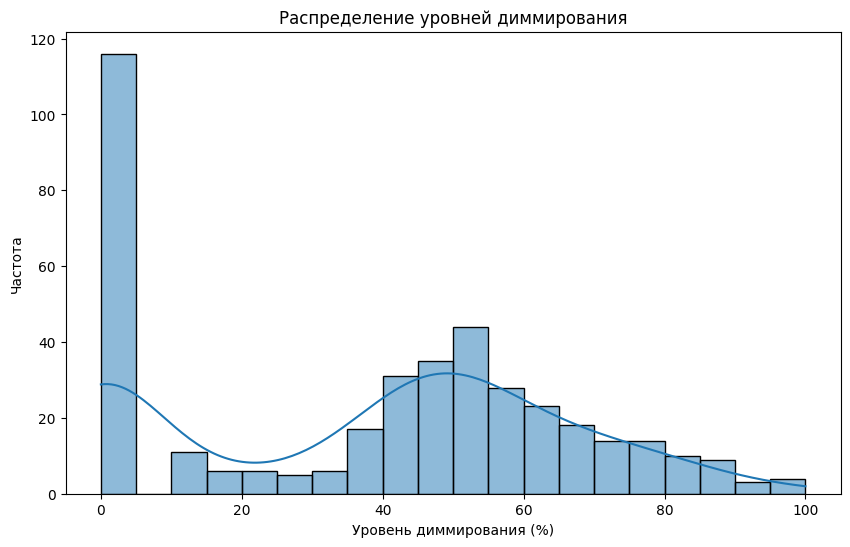

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(df['dimming_level'], bins=20, kde=True)
plt.title('Распределение уровней диммирования')
plt.xlabel('Уровень диммирования (%)')
plt.ylabel('Частота')
plt.show()

In [52]:
def prepare_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    y = df['dimming_level']
    X = df.drop(['id', 'timestamp', 'longitude', 'latitude', 'serial_number', 'lamp_power', 'dimming_level'], axis=1)
    return X, y

X, y = prepare_data(df)


In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Тренировочный набор: {X_train.shape[0]} записей")
print(f"Тестовый набор: {X_test.shape[0]} записей")

Тренировочный набор: 320 записей
Тестовый набор: 80 записей


In [57]:
numeric_features = ['car_count', 'traffic_speed', 'traffic_density',
                   'pedestrian_count', 'pedestrian_density', 
                   'ambient_light', 'hour', 
                   'day_of_week', 'is_weekend']

categorical_features = ['lighting_class', 'weather']

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

preprocessor.fit(X_train)
X_test_processed = preprocessor.transform(X_test)

In [59]:
model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    early_stopping_rounds=10,
    eval_metric='mae'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [60]:
pipeline.fit(
    X_train, y_train,
    model__eval_set=[(X_test_processed, y_test)],
    model__verbose=True
)

[0]	validation_0-mae:21.11936
[1]	validation_0-mae:19.50457
[2]	validation_0-mae:17.88509
[3]	validation_0-mae:16.49351
[4]	validation_0-mae:15.24470
[5]	validation_0-mae:14.13771
[6]	validation_0-mae:13.21608
[7]	validation_0-mae:12.47325
[8]	validation_0-mae:11.81044
[9]	validation_0-mae:11.13709
[10]	validation_0-mae:10.55647
[11]	validation_0-mae:10.08405
[12]	validation_0-mae:9.67150
[13]	validation_0-mae:9.23519
[14]	validation_0-mae:8.88327
[15]	validation_0-mae:8.59080
[16]	validation_0-mae:8.26147
[17]	validation_0-mae:8.06358
[18]	validation_0-mae:7.90840
[19]	validation_0-mae:7.71723
[20]	validation_0-mae:7.60201
[21]	validation_0-mae:7.47505
[22]	validation_0-mae:7.37942
[23]	validation_0-mae:7.24557
[24]	validation_0-mae:7.15484
[25]	validation_0-mae:7.07602
[26]	validation_0-mae:7.00418
[27]	validation_0-mae:6.99204
[28]	validation_0-mae:6.93247
[29]	validation_0-mae:6.89692
[30]	validation_0-mae:6.84956
[31]	validation_0-mae:6.82008
[32]	validation_0-mae:6.78894
[33]	val

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


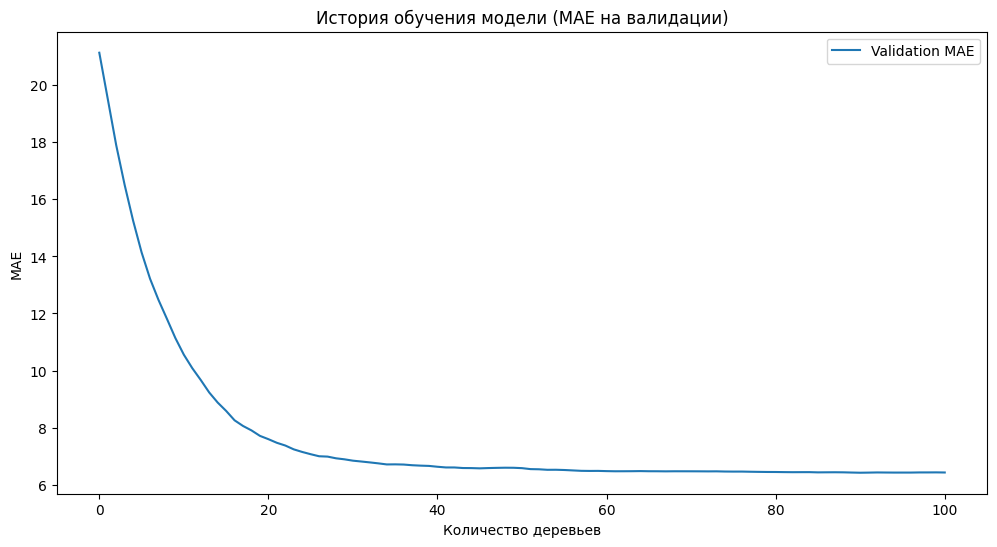

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(model.evals_result()['validation_0']['mae'], label='Validation MAE')
plt.title('История обучения модели (MAE на валидации)')
plt.xlabel('Количество деревьев')
plt.ylabel('MAE')
plt.legend()
plt.show()

Средняя абсолютная ошибка (MAE): 6.43
Коэффициент детерминации (R²): 0.86


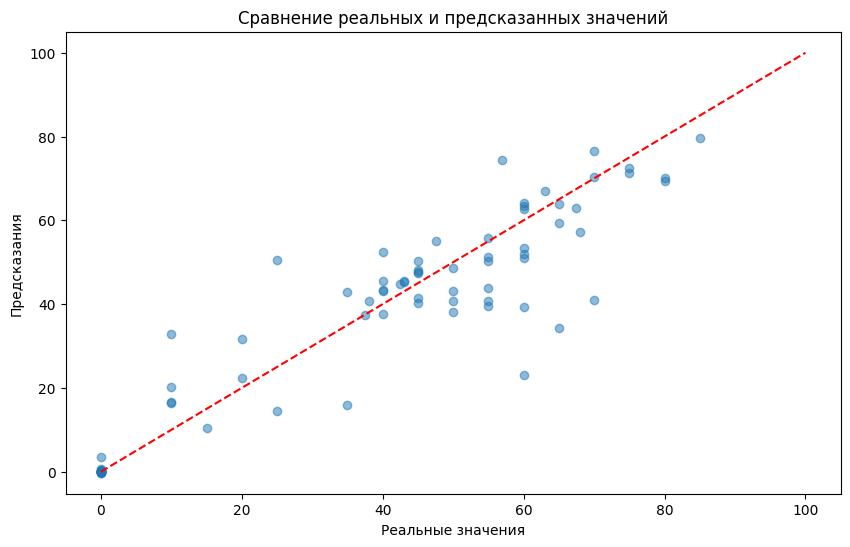

In [62]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
    print(f"Коэффициент детерминации (R²): {r2:.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказания')
    plt.title('Сравнение реальных и предсказанных значений')
    plt.show()
    
    return mae, r2

mae, r2 = evaluate_model(pipeline, X_test, y_test)

In [67]:
model_filename = 'model_xgboost.joblib'
joblib.dump(pipeline, model_filename)
print(f"Модель сохранена как {model_filename}")

Модель сохранена как model_xgboost.joblib


Использование:

In [76]:
def predict_dimming(sample_data):
    model = joblib.load(model_filename)
    prediction = model.predict(pd.DataFrame([sample_data]))[0]
    return max(0, min(100, prediction))

sample_data = {
    'car_count': 9,
    'traffic_speed': 24.38,
    'traffic_density': 0.11,
    'pedestrian_count': 0,
    'pedestrian_density': 0.0,
    'ambient_light': 30000,
    'lighting_class': 'B1',
    'weather': 'clouds',
    'hour': 15,
    'day_of_week': 3,
    'is_weekend': 0
}

prediction = predict_dimming(sample_data)
print(f"Предсказанный уровень диммирования: {prediction:.1f}%")

Предсказанный уровень диммирования: 0.8%
